## Best fitting parameters.
In this notebook we would use the ODE based model to find out the best fitting parameters, using different standard and non-standard packages. Please feel free to use this an an example template to get started with your own workflow. Good luck.

First we are going to load the data.

In [3]:
import csv
import pandas as pd

In [5]:
data = pd.read_csv("./../data/in_silico_growth_curve.csv")

Let's see what the datafile contents are.

In [6]:
data

,times,cells
0,0.000000,8677.144668
1,1.500000,26920.855990
2,3.000000,63176.862474
3,4.500000,249712.054657
4,6.000000,442178.369581
5,7.500001,802923.563655
6,9.000001,875907.621559
7,10.500001,856617.310790
8,12.000001,885705.601724
9,13.500001,912408.715922


It's a very small dataset with just 10 time points showing the number of cells over time. With these short time series, both having a mechanistic model to fit it and having a Bayesian framework to do so helps us to make better sense of the science behind the process. We can visualize the data as.

Text(0, 0.5, 'cells')

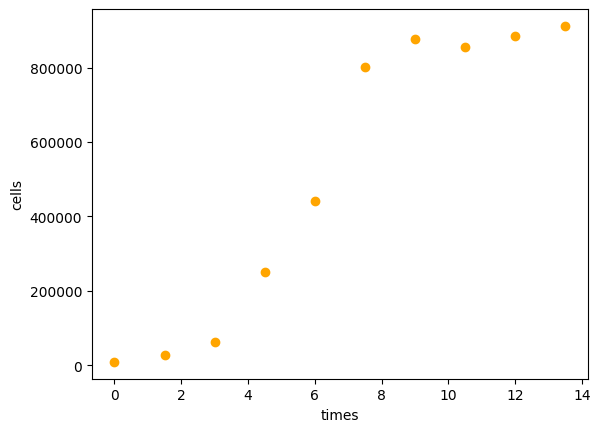

In [138]:
import matplotlib.pyplot as plt
plt.plot(data['times'],data['cells'],'o',color ='orange')
plt.xlabel(data.columns[0])
plt.ylabel(data.columns[1])


However that can be complicated, let's start with the most simple way of fitting a nonlinear ODE model to the data.

### Use of Biological Mechanistic knowledge.
This data is a growth data of the cells where they consume nutrients and we can use the blahblah model

$$
\frac{dN}{dt} = -Q_n \frac{\mu_{max}N}{N+K_s}(P\times10^6)
$$

$$
\frac{dP}{dt} = \frac{\mu_{max}N}{N+K_s} P
$$

### In this dataset the variable 'N' (nutrients) is latent (unobserved)

In [63]:
import numpy as np
from scipy.integrate import odeint
t = np.linspace(0, 15, 100)

def cells_grow(y,t,mu_max,Ks,Qn):
    N, P = y
    dydt = [0,0]
    dydt[0] = -Qn*(mu_max*N)/(N+Ks) *(P*1e6)
    dydt[1] = P*(mu_max*N)/(N+Ks)

    return dydt

def solved_num_cells(y0,t,mu_max,Ks,Qn):
    sol = odeint(cells_grow, y0, t, args=(mu_max,Ks,Qn))
    return sol[:,1]

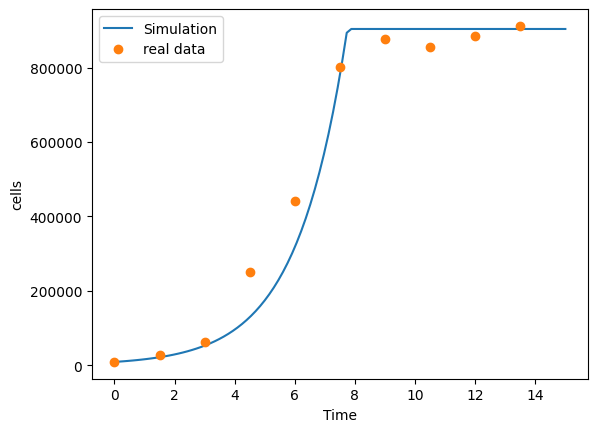

In [64]:
mu_max = 0.6
Ks = 0.09
Qn = 6.7e-10

y0 = [ 6e2, data['cells'][0] ]
num_cells_solved = solved_num_cells(y0,t,mu_max,Ks,Qn)

plt.plot(t,num_cells_solved)
plt.plot(data['times'],data['cells'],'o')
plt.legend(['Simulation','real data'])
plt.xlabel('Time')
plt.ylabel('cells')
plt.show()


### Using least square regression (scipy)

Often microbial data spans across orders of magnitude and fitting without transforming to log-scale would only place emphasis on the higher orders of magnitude and can completely ignore the lower order of magnitudes.

In [129]:
from scipy.optimize import least_squares

# Define the cost function
def cost_function(params, data, log_transformed = True):
    mu_max, Ks, Qn, N0 = params
    y0 = [ N0, data['cells'][0] ]
    num_cells_solved = solved_num_cells(y0, data['times'], mu_max, Ks, Qn)
    #return (num_cells_solved - data['cells']) 
    if log_transformed is True:
        #error  =  np.sum((np.log(num_cells_solved)/2.303 - np.log(data['cells'])/2.303)**2)
        #error  =  np.log(num_cells_solved)/2.303 - np.log(data['cells'])/2.303
        ## please do not manaully write sum of square errors, the least_square module does it for you.
        
        error  =  (np.log(num_cells_solved)/2.303 - np.log(data['cells'])/2.303).values.flatten()
    else:
        #error  =  np.sum((num_cells_solved - data['cells'] )**2) # was a mistake
        error  =  (num_cells_solved - data['cells']).values.flatten()
    return error


# Initial guess for the parameters
initial_guess = [0.5, 1, 6.7e-10, 6e2]

# Least squares fitting
result = least_squares(cost_function, initial_guess, args=(data,),
                       loss = 'linear',verbose=2)

# Check the final cost value
print(f"Final cost value: {result.cost}")

# Optimized parameters
mu_max_opt, Ks_opt, Qn_opt, N0_opt = result.x
print(f"Optimized parameters: mu_max={mu_max_opt}, Ks={Ks_opt}, Qn={Qn_opt}, N0={N0_opt}")

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.9565e-01                                    4.55e+07    
       1              4         2.7539e-01      2.03e-02       3.75e+01       1.14e+08    
       2             16         2.7539e-01      0.00e+00       0.00e+00       1.14e+08    
`xtol` termination condition is satisfied.
Function evaluations 16, initial cost 2.9565e-01, final cost 2.7539e-01, first-order optimality 1.14e+08.
Final cost value: 0.2753918731596441
Optimized parameters: mu_max=0.6457273672100075, Ks=36.98094242731047, Qn=1.4206079262430242e-09, N0=610.5643470403767


In [131]:
# Define the cost function
def cost_function_ls(params, data, log_transformed = True):
    mu_max, Ks, Qn, N0 = params
    y0 = [ N0, data['cells'][0] ]
    num_cells_solved = solved_num_cells(y0, data['times'], mu_max, Ks, Qn)
    #return (num_cells_solved - data['cells']) 
    if log_transformed is True:
        #error  =  np.sum((np.log(num_cells_solved)/2.303 - np.log(data['cells'])/2.303)**2)
        #error  =  np.log(num_cells_solved)/2.303 - np.log(data['cells'])/2.303
        ## please do not manaully write sum of square errors, the least_square module does it for you.
        
        error  =  np.sum( (np.log(num_cells_solved)/2.303 - np.log(data['cells'])/2.303)**2 )
    else:
        #error  =  np.sum((num_cells_solved - data['cells'] )**2) # was a mistake
        error  =  np.sum( (num_cells_solved - data['cells'])**2 )
    return error



In [132]:
cost_function_ls( [0.5, 20, 6.7e-10,10e2], data)

0.8095024146444206

In [134]:
cost_function_ls( [mu_max_opt, Ks_opt, Qn_opt,N0_opt], data)

0.5507837463192881

__You can also use solve_ivp to solve the ODEs__

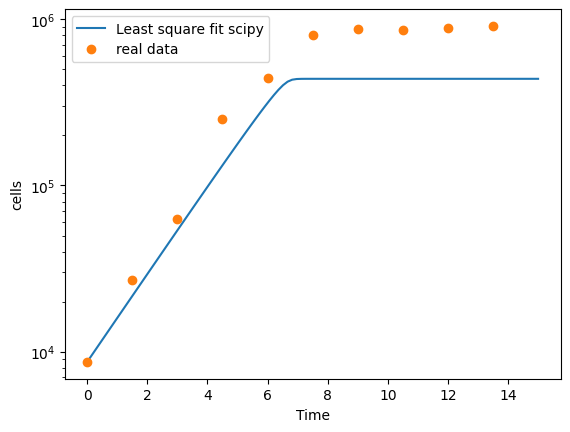

In [136]:
y0 = [  N0_opt, data['cells'][0] ]
num_cells_solved = solved_num_cells(y0,t,mu_max_opt, Ks_opt, Qn_opt)

plt.plot(t,num_cells_solved)
plt.yscale('log')
plt.plot(data['times'],data['cells'],'o')
plt.legend(['Least square fit scipy','real data'])
plt.xlabel('Time')
plt.ylabel('cells')
plt.show()


### Using curvefit

Should not do this as this is highly unstable -- this method works fine for closed form solutions -- gets difficult for where we only have ODE which is to be solved numerically.

### Define a cost function and using tensorflow minimize the gradient.

In [144]:
import tensorflow as tf


# Define the cost function for TensorFlow
def cost_function_tf(params, cells, times, log_transformed=True):
    mu_max, Ks, Qn, N0 = params
    y0 = [N0, cells[0]]
    num_cells_solved = solved_num_cells(y0, times, mu_max, Ks, Qn)
    if log_transformed:
        error = tf.reduce_sum((tf.math.log(num_cells_solved) / 2.303 - tf.math.log(cells) / 2.303) ** 2)
    else:
        error = tf.reduce_sum((num_cells_solved - cells) ** 2)
    return error

# Initial guess for the parameters
initial_guess = np.array([0.5, 20, 6.7e-10, 10e2], dtype=np.float64)

# Convert initial guess to TensorFlow variable
params = tf.Variable(initial_guess)

# Convert data to TensorFlow tensors
cells = tf.constant(data['cells'], dtype=tf.float64)
times = tf.constant(data['times'], dtype=tf.float64)

# Set up the optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Training loop
for i in range(1000):  # Number of iterations
    with tf.GradientTape() as tape:
        loss = cost_function_tf(params, cells, times, log_transformed=True)
    grads = tape.gradient(loss, [params])
    optimizer.apply_gradients(zip(grads, [params]))
    if i % 100 == 0:  # Print every 100 iterations
        print(f"Iteration {i}: Loss = {loss.numpy()}")

# Optimized parameters
mu_max_opt, Ks_opt, Qn_opt, N0_opt = params.numpy()
print(f"Optimized parameters: mu_max={mu_max_opt}, Ks={Ks_opt}, Qn={Qn_opt}, N0={N0_opt}")

ValueError: No gradients provided for any variable.

Did not work -- will debug later. I will write it in my own way now.

In [147]:
mu_max_guess =  0.5 
Ks_guess = 20
Qn_guess = 6.7e-10
N0_guess = 10e2

# Define your optimization variables
mu_max =  tf.Variable(mu_max_guess, np.float64)
Ks =  tf.Variable(Ks_guess, np.float64)
Qn =  tf.Variable(Qn_guess, np.float64)
N0 =  tf.Variable(N0_guess, np.float64)

# Convert data to TensorFlow tensors
cells = tf.constant(data['cells'], dtype=tf.float64)
times = tf.constant(data['times'], dtype=tf.float64)




In [151]:
# Define the cost function for TensorFlow
def cost_function_tf(mu_max, Ks, Qn, N0,cells,times ):
    y0 = [N0, cells[0]]
    num_cells_solved = solved_num_cells(y0, times, mu_max, Ks, Qn)
    if log_transformed:
        error = tf.reduce_sum((tf.math.log(num_cells_solved) / 2.303 - tf.math.log(cells) / 2.303) ** 2)
    else:
        error = tf.reduce_sum((num_cells_solved - cells) ** 2)
    return error

In [154]:
cells 

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([  8677.14466756,  26920.85598952,  63176.8624745 , 249712.05465716,
       442178.36958117, 802923.56365537, 875907.62155877, 856617.31079041,
       885705.60172384, 912408.71592194])>

In [ ]:
cost_function_tf(mu_max, Ks, Qn, N0,cells,times)